# Talking motion signature of individuals

**An attempt to reconstruct the experiment conveyed by Matyas Bohacek**

In [39]:
import numpy as np
import pandas as pd
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [40]:
CORRELATIONS = ""
EXAMPLE_EXTRACTED = ""
if "kaggle" in os.getcwd():
    print(f"Running in kaggle...")
    CORRELATIONS = "/kaggle/input/correlations/correlations.csv"
else:
    print(f"Running locally...")
    CORRELATIONS = os.path.join("data", "correlations.csv")
    EXAMPLE_EXTRACTED = "data/extracted/1_id0_celeb_clip_0.csv"


cors = pd.read_csv(CORRELATIONS, index_col="clip_name")
print("The cor dataset was loaded successfully")

extracted_ex = pd.read_csv(EXAMPLE_EXTRACTED)
print("Example extracted features loaded successfully.")

Running locally...
The cor dataset was loaded successfully
Example extracted features from OpenFace and MediaPipe loaded successfully.


## Data Exploration and Analysis

### General information:
The dataset used in this particular implementstion encompasses:
1. **... minutes** of pristine videos of ... individuals, taken from VoxCeleb_v2

### Temporal information:
- Most of the videos are 4-10 seconds of length.

### Video preprocessing:
- Videos were not preprocessed at all:
    - Some of the frames do not contain a person at all
    - Several frames may also contain transitions
- Videos are also separated into small clips Xs each overlapping by Y seconds clips

### Data extraction
- Normalised body landmarks, AUs and head rotations are then extracted from the clips
- To represent some complex movements, temporal correlation are extracted for all detected features.

### Dataset explanation
- The dataset's index conveniently denotes from which video and clip the data was extracted.

**Example:**
`id01026_xGwXIrtXn7w_00098.mp4`:
   - `id01026` id of an individual
   - `xGwXIrtXn7w` video id
   - `00098` person's occurence

   *in case it is a clip of this video, one part is added: `id01026_xGwXIrtXn7w_00098_clip_0.mp4`*
   - `clip_0` where 0 is an id of a clip

    
- Columns of the dataset are correlations bewtween the extracted features. the template is `feature1*feature2`. Total number of correlations: **...**

**Example:**
`leftShoulder_X*rightShoulder_X`

- Total number of clips extracted is **...**

To better understand the data, exploration of non-transformed features has to be made

In [41]:
display(extracted_ex.head(5))
display(extracted_ex.info())

,frame,face_id,timestamp,confidence,success,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0,0.000,0.98,1,218.9,-120.7,1051.9,0.165,0.230,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,2,0,0.033,0.98,1,219.2,-120.9,1053.6,0.173,0.241,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2,3,0,0.067,0.98,1,222.2,-124.4,1072.4,0.170,0.233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,0,0.100,0.98,1,226.2,-128.0,1093.1,0.165,0.221,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,0,0.133,0.98,1,226.0,-128.0,1092.9,0.166,0.215,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 46 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   frame       300 non-null    int64  
 1   face_id     300 non-null    int64  
 2   timestamp   300 non-null    float64
 3   confidence  300 non-null    float64
 4   success     300 non-null    int64  
 5   pose_Tx     300 non-null    float64
 6   pose_Ty     300 non-null    float64
 7   pose_Tz     300 non-null    float64
 8   pose_Rx     300 non-null    float64
 9   pose_Ry     300 non-null    float64
 10  pose_Rz     300 non-null    float64
 11  AU01_r      300 non-null    float64
 12  AU02_r      300 non-null    float64
 13  AU04_r      300 non-null    float64
 14  AU05_r      300 non-null    float64
 15  AU06_r      300 non-null    float64
 16  AU07_r      300 non-null    float64
 17  AU09_r      300 non-null    float64
 18  AU10_r      300 non-null    float64
 19  AU12_r      300 non-null    f

None

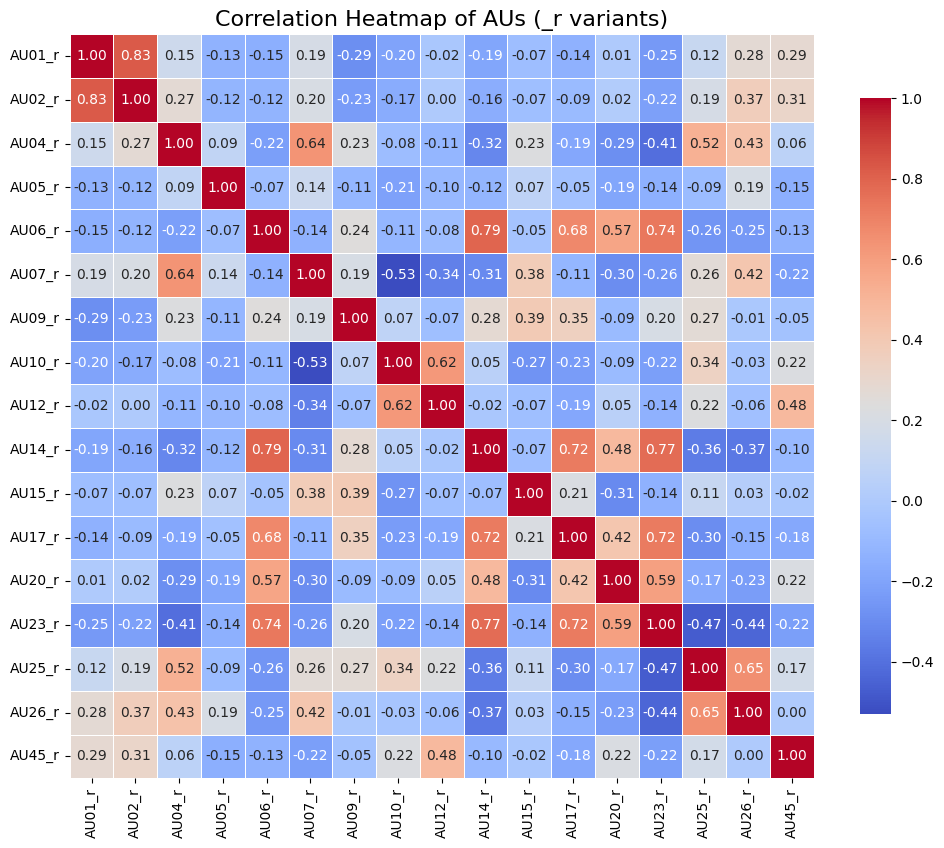

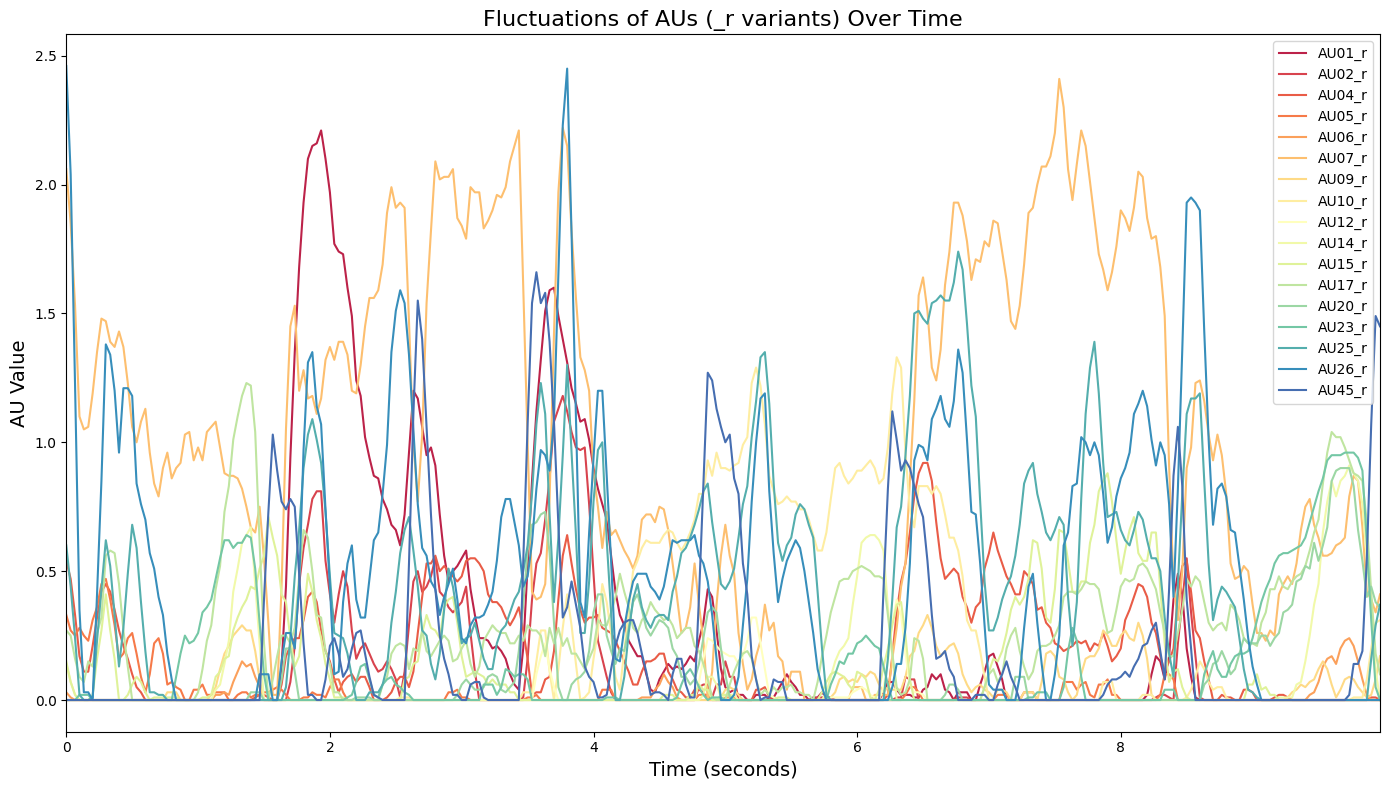

In [44]:
au_r_columns = [col for col in extracted_ex.columns if '_r' in col]
correlation_matrix = extracted_ex[au_r_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Correlation Heatmap of AUs (_r variants)', fontsize=16)
plt.show()
plt.figure(figsize=(14, 8))
colors = sns.color_palette("Spectral", len(au_r_columns))  
for au, color in zip(au_r_columns, colors):
    plt.plot(extracted_ex.index / 30, extracted_ex[au], label=au, color=color)
plt.title('Fluctuations of AUs (_r variants) Over Time', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('AU Value', fontsize=14)
plt.xlim(0, extracted_of_ex.index[-1] / 30)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

To check whether the dependencies between the AUs really make sense, here's a concise [description](https://imotions.com/blog/learning/research-fundamentals/facial-action-coding-system/) of AUs.

At the same time, the clip itself is also present:

[clip](data/media/video/example_clip.mp4)


In [48]:
DATAPOINTS_CNT = len(cors)
FEATURES_CNT = len(cors.columns)
CELLS_CNT = DATAPOINTS_CNT * FEATURES_CNT
NAN_THRESHOLD_P = 0.07
NAN_THRESHOLD_V = NAN_THRESHOLD_P * FEATURES_CNT

# cors.isnull() Return a bitmap for all cells (True/False)
nan_total_ratio = cors.isnull().sum().sum() / CELLS_CNT
print(f"Ratio of NaN values to in the dataset: {nan_total_ratio:.2%}")

nan_row_ratio = cors.isnull().any(axis=1).sum() / DATAPOINTS_CNT
print(f"Ratio of datapoints which have NaN values in them: {nan_row_ratio:.2%}")

nan_row_ratio = (cors.isnull().sum(axis=1) > NAN_THRESHOLD_V).sum() / DATAPOINTS_CNT
print(f"Ratio of datapoints which have more than {NAN_THRESHOLD_P:.2%} NaN values in them: {nan_row_ratio:.2%}, \
[actual NaN features cnt thresh.: {NAN_THRESHOLD_V:.0f}]")

nan_col_ratio = cors.isnull().any().sum() / FEATURES_CNT
print(f"Ratio of features which have NaN values in them: {nan_col_ratio:.2%}")

Ratio of NaN values to in the dataset: 3.97%
Ratio of datapoints which have NaN values in them: 39.00%
Ratio of datapoints which have more than 7.00% NaN values in them: 10.94%, [actual NaN features cnt thresh.: 30]
Ratio of features which have NaN values in them: 100.00%


Not surprisingly, **39%** of datapoints have `np.NaN`s in them, and only **11%** of the total number of the datapoints have more than **7%** of their features as `np.NaN`s.

To solve this issue, the following operations will be performed:
- Rows which have more than **7%** of `np.NaN`s in them will be excluded from the dataset.
- Rows which have less than **7%** of `np.NaN`s in them will be refined by changing replacing `np.NaN`s with means.

In [49]:
cors = cors[cors.isna().sum(axis=1) <= NAN_THRESHOLD_V]
print("Datapoints left:", len(cors))

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
for column in cors.columns:
    cors[column] = imputer.fit_transform(cors[[column]])
    
print(f"Control - number of NaNs in the dataset:", cors.isnull().sum().sum())

Datapoints left: 7182
Control - number of NaNs in the dataset: 0


Now, let's take a look for the possible insights that this data can potentially hide

To further control how certain features describe the identity lets split the dataset into 3:
- All feature combined
- Only facial
- Only body

In [50]:
cors_full = cors

body_columns = [col for col in cors.columns if col.endswith('_X') or col.endswith('_Y')]
cors_body = cors[body_columns]

face_columns = [col for col in cors.columns if not (col.endswith('_X') or col.endswith('_Y'))]
cors_face = cors[face_columns]

Add the `y` pd.Series which would represent the target variable

In [51]:
y = pd.Series(cors.index.str.contains("pristine"))

Although all of the features are Pearson correlations, still, they can be standardized to avoid potential probllems because distribution of each feature is unknown at this point. (Irrational to check each one)

In [52]:
scaler = StandardScaler()

X_full = scaler.fit_transform(cors_full)
X_body = scaler.fit_transform(cors_body)
X_face = scaler.fit_transform(cors_face)

#### Model training

In [55]:
def base_model(X: np.ndarray):
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'poly']
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best accuracy:", grid_search.best_score_)

    best_svm = grid_search.best_estimator_
    best_svm.fit(X_train, y_train)

    y_pred = best_svm.predict(X_test)
    
    # Visualizations
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Pristine', 'Pristine'], yticklabels=['Not Pristine', 'Pristine'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, best_svm.decision_function(X_test))
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

Train the first full model to have a baseline

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.9665796344647519


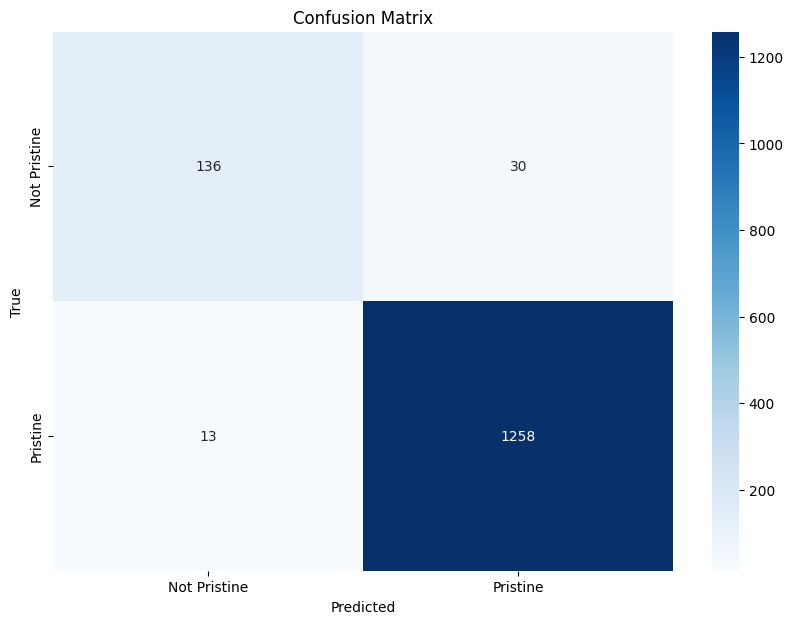

              precision    recall  f1-score   support

       False       0.91      0.82      0.86       166
        True       0.98      0.99      0.98      1271

    accuracy                           0.97      1437
   macro avg       0.94      0.90      0.92      1437
weighted avg       0.97      0.97      0.97      1437



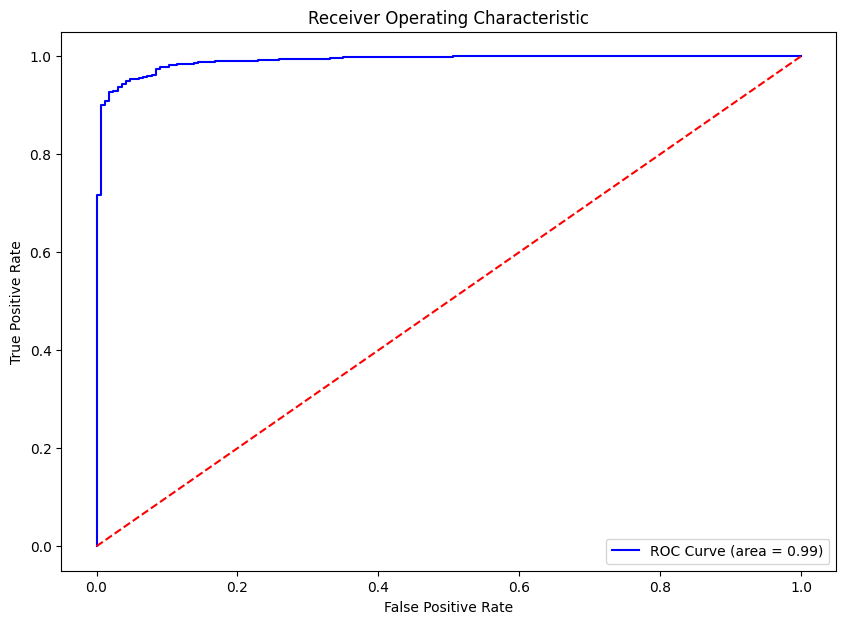

In [56]:
base_model(X_full)

Now the body-only

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.9096605744125327


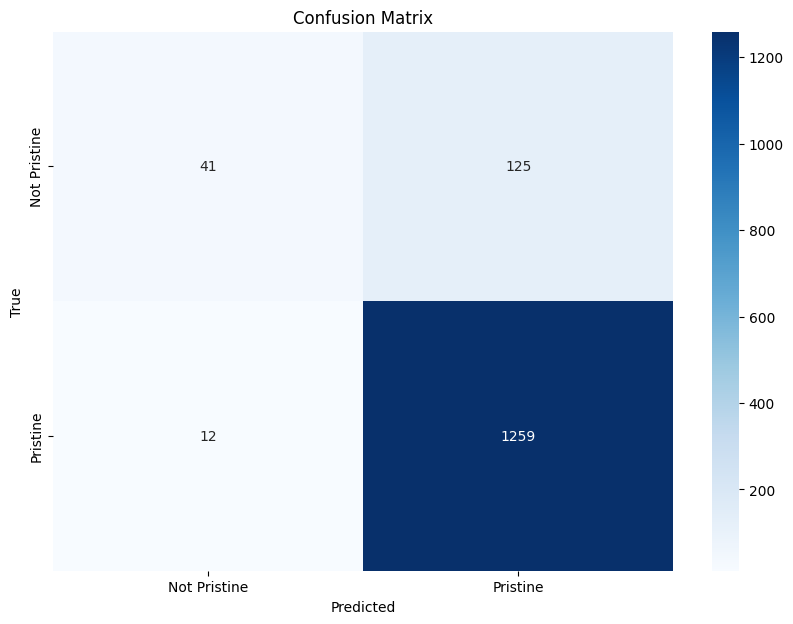

              precision    recall  f1-score   support

       False       0.77      0.25      0.37       166
        True       0.91      0.99      0.95      1271

    accuracy                           0.90      1437
   macro avg       0.84      0.62      0.66      1437
weighted avg       0.89      0.90      0.88      1437



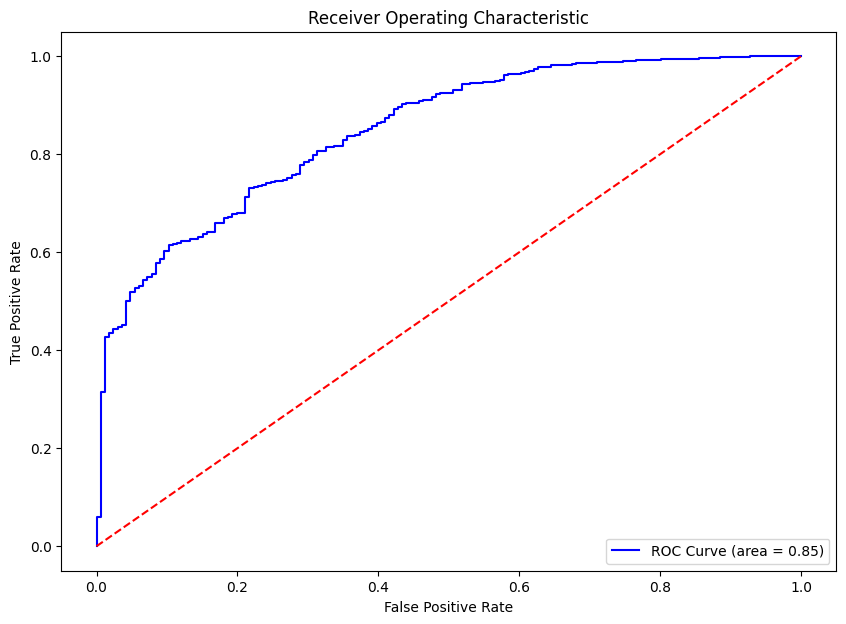

In [57]:
base_model(X_body)

And the face-only

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.9658833768494344


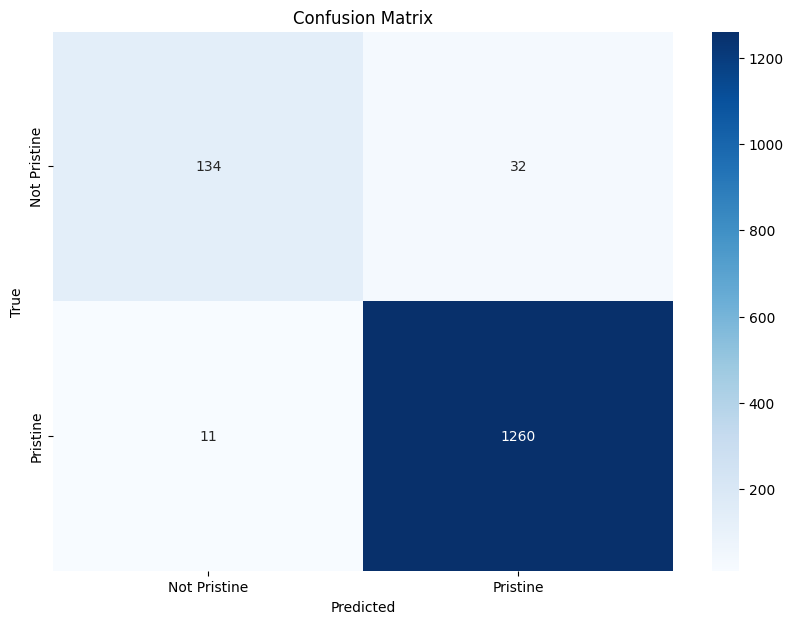

              precision    recall  f1-score   support

       False       0.92      0.81      0.86       166
        True       0.98      0.99      0.98      1271

    accuracy                           0.97      1437
   macro avg       0.95      0.90      0.92      1437
weighted avg       0.97      0.97      0.97      1437



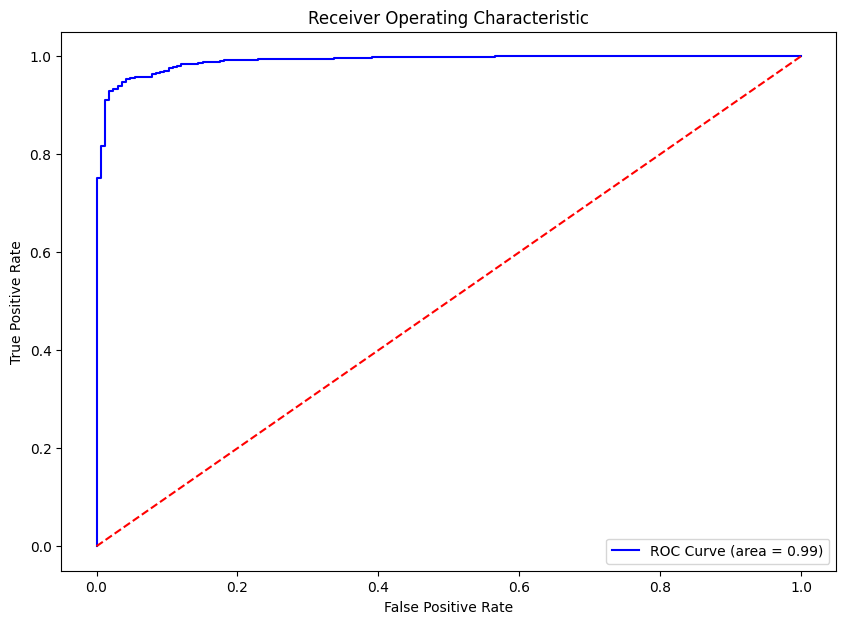

In [58]:
base_model(X_face)

Run the full model for 10 times to get its average performance

In [59]:
# f1 = []

# for i in range(0,10):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1', n_jobs=-1)
#     grid_search.fit(X_train, y_train)
    
#     best_svm = grid_search.best_estimator_
#     best_svm.fit(X_train, y_train)
    
#     f1.append(best_svm.predict(X_test))
    
# print("Average f1 through 10 random splits: ", sum(f1)/len(f1))

#### Simple visualization

/home/samarrik/projects/protecting_zelenskyi/venv_zel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


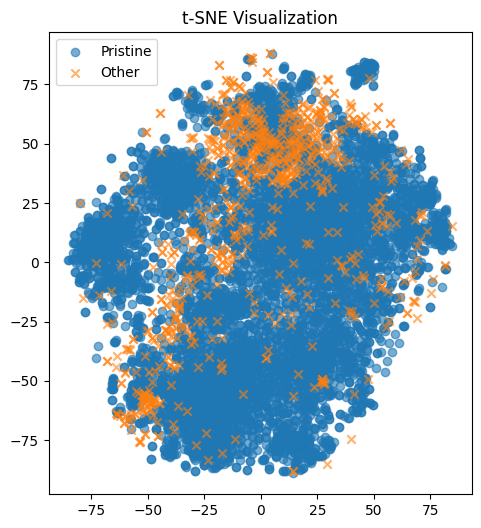

In [60]:
# Adjust PCA components
pca = PCA(n_components=50)  # Increased to 50 components
X_pca = pca.fit_transform(X_full)

tsne = TSNE(
    n_components=2,
    n_iter=3000,          # Increased iterations
    perplexity=40,        # Adjusted perplexity
    learning_rate=200,    # Adjusted learning rate
    random_state=42
)
X_tsne = tsne.fit_transform(X_pca)

# Plotting the t-SNE results
plt.figure(figsize=(12, 6))

# t-SNE subplot
plt.subplot(1, 2, 1)
plt.scatter(
    X_tsne[y == 1, 0],
    X_tsne[y == 1, 1],
    label="Pristine",
    alpha=0.6,
    marker='o'
)
plt.scatter(
    X_tsne[y == 0, 0],
    X_tsne[y == 0, 1],
    label="Other",
    alpha=0.6,
    marker='x'
)
plt.title('t-SNE Visualization')
plt.legend()
plt.show()

In [ ]:
# self-similarity

In [ ]:
# size of the clips

In [ ]:
# komprese